In [1]:
import networkx as nx
from scipy.sparse import linalg as scp_sla
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.util as util
import sim_lib.attr_lib.util as attr_util
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 5

params = {
    'context_count' : 8,
    'k' : 8,
    'attr_func' : attr_util.discrete_pareto_val, # attribute assignment function
    'edge_util_func' : attr_util.total_inv_frequency,
    'edge_proposal' : attr_util.const_one,
    'vtx_util' : attr_util.logistic,
    'edge_selection' : attr_util.seq_projection_single_selection,
    'attr_copy' : attr_util.freq_attr_copy,
    'seed_type' : 'clique', # Type of seed network
    'vtx_budget' : 8 * 20,
    'vtx_types' :
        {
            'wide' : { 'direct_cost' : 10,
                      'indirect_cost' : 30,
                      'likelihood' : 0.0,
                      'struct_util' : attr_util.ball2_size,
                      'color' : 'blue' },
            'tall' : { 'direct_cost' : 30,
                      'indirect_cost' : 10,
                      'likelihood' : 1.0,
                      'struct_util' : attr_util.neighborhood_density,
                      'color' : 'red' }
        }
}

assert sum([ t['likelihood'] for t in params['vtx_types'].values() ]) == 1.0

In [3]:
def graph_density(G):
    denum = (G.num_people * (G.num_people - 1))
    num = sum([ v.degree for v in G.vertices])
    return num / denum

def second_eigv(G):
    G_nx = gnx.graph_to_nx(G)
    laplacian = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_nx)
    eigvals = scp_sla.eigs(laplacian, return_eigenvectors=False)
    eigvals.sort()
    return eigvals[1]

def apl(G):
    G_nx = gnx.graph_to_nx(G)
    return nx.average_shortest_path_length(G_nx)

def diam(G):
    G_nx = gnx.graph_to_nx(G)
    return nx.diameter(G_nx)

def social_edge_welfare(G):
    return sum([ v.total_edge_util for v in G.vertices ]) / 2

def modularity(G):
    partitions = nx_comm.greedy_modularity_communities(G_nx)
    return nx_comm.modularity(G_nx, partitions)

In [4]:
def plot_distributions(G):
    
    # Degree distribution
    degree_dist = [ v.degree for v in G.vertices ]
    norm_degree_dist = []
    if max(degree_dist) == 0:
        norm_degree_dist = [ 0 for d in degree_dist ]
    else:
        norm_degree_dist = [ d / max(degree_dist) for d in degree_dist ]
    
    G_nx = gnx.graph_to_nx(G)
    eigv_centralities = nx.eigenvector_centrality(G_nx, weight='util')
    eigv_centralities = list(eigv_centralities.values())
    
    metric_dists = [norm_degree_dist, eigv_centralities]
    dist_labels = ['norm degree', 'eigenvector cent']
    
    bins = np.linspace(0, 1, 100)
    plt.hist(metric_dists, bins, alpha=0.5, label=dist_labels)
    plt.legend(loc='upper right')
    plt.show()
    

In [5]:
def print_metrics(G):
    gd = graph_density(G)
    eig2 = second_eigv(G)
    sw = social_edge_welfare(G)
    try:
        avg_pl = apl(G)
    except:
        avg_pl = -1
    try:
        diameter = diam(G)
    except:
        diameter = -1
    
    print("""Graph density: {0}, \n
    average path length: {1}, \n
    diameter: {2}, \n
    second eigenvalue: {3}, \n
    social edge welfare: {4} \n""".format(gd, avg_pl, diameter, eig2, sw))

0
-----------------------------------------
Vertex 0 degree 4
[(-0.2564102564102565, 0.0, 0.375), (-0.3105413105413107, 0.0, 0.375), (-0.06552706552706561, 0.0, 0.375), (-0.08689458689458697, 0.0, 0.375)]
[0.1185897435897435, 0.06445868945868932, 0.3094729344729344, 0.28810541310541304]
chose 2 (-0.06552706552706561, 0.0, 0.375)
chosen vtx Vertex 3
chose to drop
###########################
Vertex 1 degree 4
[(-0.21017699115044242, -0.16666666666666674, 0.375), (-0.21681415929203535, 0.16666666666666663, 0.3125), (-0.19690265486725664, -0.16666666666666674, 0.375), (-0.27654867256637156, 0.16666666666666663, 0.3125)]
[-0.0018436578171091567, 0.2623525073746313, 0.011430678466076594, 0.20261799410029507]
chose 1 (-0.21681415929203535, 0.16666666666666663, 0.3125)
chosen vtx Vertex 3
chose to drop
###########################
Vertex 2 degree 4
[(-0.1813271604938274, 0.33333333333333337, 0.25), (-0.2067901234567904, -0.3333333333333333, 0.375), (-0.3827160493827163, 0.0, 0.3125), (-0.206790

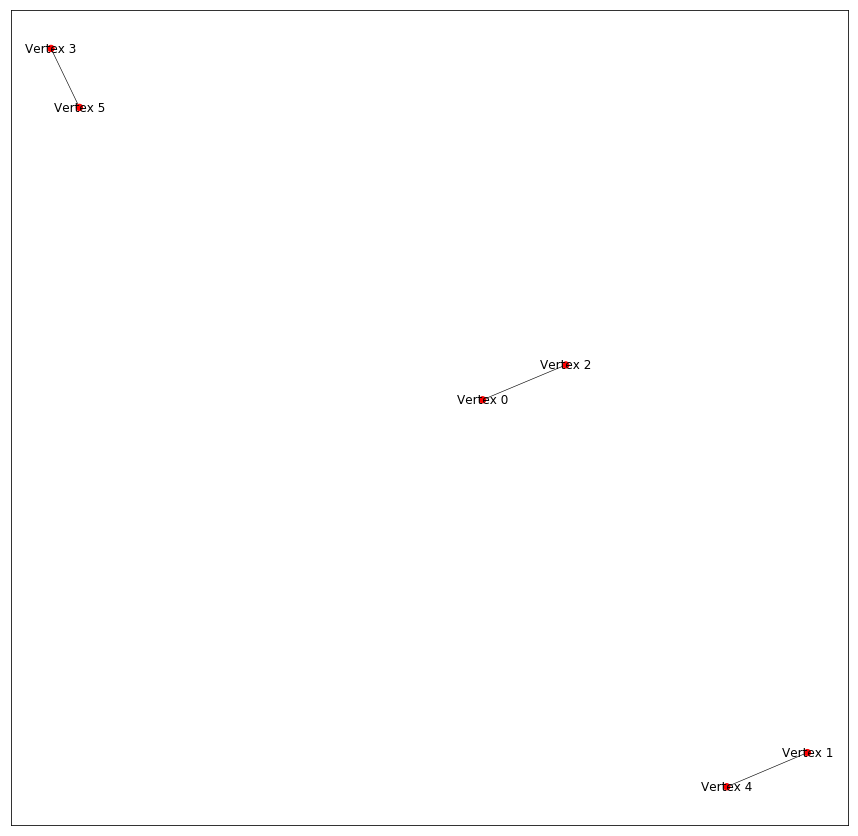

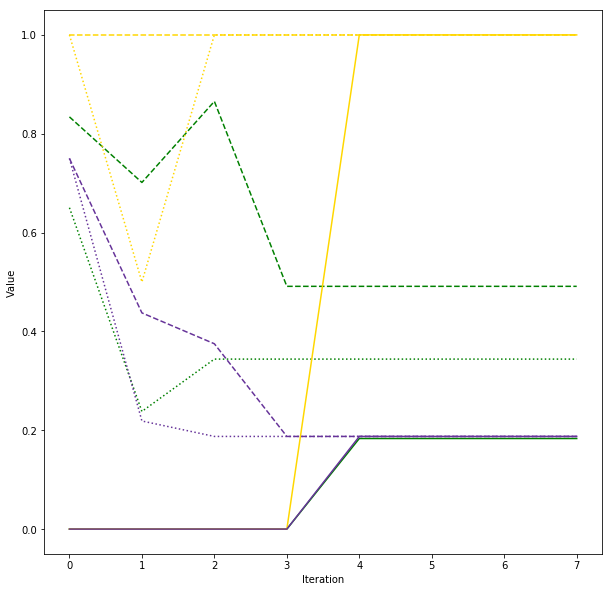

In [6]:
G = attribute_network(_N, params)

num_iters = 8
add_to_iter = 1

summary_stat_vals = ['attr_util', 'struct_util', 'cost']
summary_funcs = [ min, max, np.median ]
summary_func_names = ['min', 'max', 'median']
summary_stats = { val : { name : [] for name in summary_func_names } \
                 for val in summary_stat_vals }
stat_val_colors = ['green', 'gold', 'rebeccapurple']
summary_func_styles = ['-', '--', ':']

for it in range(num_iters):
    print(it)
    if it < add_to_iter:
        add_attr_graph_vtx(G)
    calc_edges(G)
    simul_random_walk(G)
    for v in [ v for v in G.vertices if v.degree == 0 ]:
        attr_util.indep_context_proposal(G, v)
        
    # Sim iter end, start stat collection
    
    attr_util_vals = [ u.total_edge_util / G.sim_params['edge_util_func'](u, u, G) \
                      for u in G.vertices ]
    struct_util_vals = [ u.data['struct_util'](u, G) for u in G.vertices ]
    costs = [ attr_util.calc_cost(u, G) for u in G.vertices ]
    values = [attr_util_vals, struct_util_vals, costs]
    
    for si in range(len(summary_stat_vals)):
        for fi in range(len(summary_funcs)):
            ss_val = summary_funcs[fi](values[si])
            summary_stats[summary_stat_vals[si]][summary_func_names[fi]].append(ss_val)
            
vis.draw_graph(G)

plt.figure(figsize=(10,10))
x_vals = list(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel("Value")
for si in range(len(stat_val_colors)):
    for fi in range(len(summary_func_styles)):
        plt.plot(x_vals,
                 summary_stats[summary_stat_vals[si]][summary_func_names[fi]],
                 color=stat_val_colors[si],
                 linestyle=summary_func_styles[fi])
plt.show()